# Black Scholes and Binomial Options Pricing Strategy

### Background Information
The Derivative: European and American Options <br>
The models: **Black Scholes** and **Binomial** models

Options are financial derivatives that give the holder the right (but not the obligation) to buy or sell an asset at a predetermined price before a specified date. The **Black-Scholes** model is a widely used formula for pricing European-style options, while the **Binomial model** is more flexible for American-style options. The **Greeks** (Delta, Gamma, Vega, Theta, and Rho) are key metrics derived from option pricing models that describe the risk sensitivities of the option.

#### Options Pricing Models
- **Black-Scholes Model**: This is a mathematical model used to price European options by estimating the option’s fair value based on factors such as the underlying asset price, strike price, volatility, time to expiration, and risk-free interest rate.
- **Binomial Model**: A discrete-time model for pricing options that allows you to calculate the option’s price step-by-step as the asset price evolves over time. This model is flexible and works well for American options (which can be exercised at any time).

#### The Greeks
- **Delta (Δ)**: Measures the sensitivity of an option’s price to changes in the price of the underlying asset. For example, a Delta of 0.5 means the option’s price will change by 0.5 units for every 1-unit change in the asset’s price.
- **Gamma (Γ)**: Measures the rate of change of Delta with respect to the underlying asset’s price. High Gamma means Delta changes rapidly, making the option more sensitive to price movements.
- **Vega (ν)**: Sensitivity of the option price to changes in the volatility of the underlying asset. High Vega means the option’s price is highly sensitive to changes in market volatility.
- **Theta (Θ)**: Measures the sensitivity of the option price to the passage of time, also known as time decay. Options lose value as they approach expiration, especially if they are out of the money.
- **Rho (ρ)**: Sensitivity of the option price to changes in the risk-free interest rate.

In [50]:
## Importing Modules for this notebook
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import minimize

For the theory behind the Black-Scholes and Binomial Models, please reference the following Bath Quant Group articles:
- [Black-Scholes Model](https://bathquantgroup.netlify.app/bspm)
- [Binomial Model](https://bathquantgroup.netlify.app/bopm)


### Step 1: Build the Option Pricing Model

In this step, we'll implement the **Black-Scholes** or **Binomial pricing model** in Python to calculate the theoretical price of options. These models are widely used to price both European and American-style options, respectively.

For more theory behind the Black-Scholes and Binomial Models, please reference the following Bath Quant Group articles:
- [Black-Scholes Model](https://bathquantgroup.netlify.app/bspm)
- [Binomial Model](https://bathquantgroup.netlify.app/bopm)

---

#### 1.1 Black-Scholes Model Implementation

The **Black-Scholes model** is used to price European-style options, which can only be exercised at expiration. The model assumes that stock prices follow a log-normal distribution and are influenced by factors like volatility, time to maturity, and interest rates.

**Black-Scholes Formula for a Call Option**: $ C = S_0 \cdot N(d_1) - X \cdot e^{-rT} \cdot N(d_2)$

**For a Put Option**: $ P = X \cdot e^{-rT} \cdot N(-d_2) - S_0 \cdot N(-d_1)$

Where:
- $C$ is the price of a call option.
- $P$ is the price of a put option.
- $S_0$ is the current price of the underlying asset.
- $X$ is the strike price of the option.
- $T$ is the time to maturity (in years).
- $r$ is the risk-free interest rate.
- $N(\cdot)$ is the cumulative distribution function (CDF) of the standard normal distribution.
- $\sigma$ is the volatility of the underlying asset.
- $d_1$ and $d_2$ are intermediate variables defined as: $d_1 = \frac{\ln(S_0 / X) + (r + \frac{\sigma^2}{2}) T}{\sigma \sqrt{T}}$, $d_2 = d_1 - \sigma \sqrt{T}$
---

In [29]:
import numpy as np
from scipy.stats import norm

def black_scholes(S, X, T, r, sigma, option_type='call'):
    # Calculate d1 and d2
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate call or put option price
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = X * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return option_price

---
#### 1.2 Binomial Option Pricing Model Implementation

The **Binomial model** is a discrete-time model used to price American-style options (which can be exercised at any time before expiration). It steps through time, creating a binomial price tree, then back-calculates the option’s value.

Steps for Binomial Model:
1. Create a binomial price tree for the stock price.
2. Calculate the option’s payoff at each node in the tree.
3. Backtrack through the tree to calculate the option price today.

Where:
- $C$ is the price of a call option.
- $P$ is the price of a put option.
- $S_0$ is the current price of the underlying asset.
- $X$ is the strike price of the option.
- $T$ is the time to maturity (in years).
- $r$ is the risk-free interest rate.
- $N(\cdot)$ is the cumulative distribution function (CDF) of the standard normal distribution.
- $\sigma$ is the volatility of the underlying asset.
- $d_1$ and $d_2$ are intermediate variables defined as: $d_1 = \frac{\ln(S_0 / X) + (r + \frac{\sigma^2}{2}) T}{\sigma \sqrt{T}}$, $d_2 = d_1 - \sigma \sqrt{T}$
---

In [30]:
def binomial_option_pricing(S, X, T, r, sigma, N, option_type='call'):
    # Calculate parameters for the binomial model
    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    q = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    
    # Initialize asset price at maturity
    stock_prices = np.zeros(N + 1)
    option_values = np.zeros(N + 1)
    
    for i in range(N + 1):
        stock_prices[i] = S * (u**i) * (d**(N - i))
    
    # Calculate the option payoff at maturity
    if option_type == 'call':
        option_values = np.maximum(stock_prices - X, 0)
    elif option_type == 'put':
        option_values = np.maximum(X - stock_prices, 0)
    
    # Backtrack to calculate option price at t=0
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            option_values[i] = np.exp(-r * dt) * (q * option_values[i + 1] + (1 - q) * option_values[i])
    
    return option_values[0]

#### 1.3 Example

In [31]:
S = 100      # Stock price
X = 110      # Strike price
T = 1        # Time to expiration in years
r = 0.05     # Risk-free interest rate (5%)
sigma = 0.2  # Volatility of the underlying asset (20%)
N = 100      # Number of time steps (only for Binomial)

# Price a call option
call_price = black_scholes(S, X, T, r, sigma, option_type='call')
print(f"Call Option Price (Black-Scholes): {call_price}")
call_price = binomial_option_pricing(S, X, T, r, sigma, N, option_type='call')
print(f"Call Option Price (Binomial): {call_price}")

# Price a put option
put_price = black_scholes(S, X, T, r, sigma, option_type='put')
print(f"Put Option Price (Black-Scholes): {put_price}")
put_price = binomial_option_pricing(S, X, T, r, sigma, N, option_type='put')
print(f"Put Option Price (Binomial): {put_price}")

Call Option Price (Black-Scholes): 6.040088129724239
Call Option Price (Binomial): 6.053224659718111
Put Option Price (Black-Scholes): 10.675324824802793
Put Option Price (Binomial): 10.68846135479751


---
### Step 2: Calculate the Greeks

In this step, we'll compute the **Greeks** of options, which measure the sensitivity of the option's price to various factors such as changes in the underlying asset price, volatility, and time. The Greeks are essential for risk management and optimizing strategies in options trading.

---

#### 2.1 The Five Key Greeks

1. **Delta (Δ)**: <br>
    Measures the rate of change of the option price with respect to changes in the price of the underlying asset.

    $\Delta = \frac{\partial C}{\partial S}$

    For a **call option**, Delta is positive, and for a **put option**, Delta is negative.

2. **Gamma (Γ)**: <br>
    Measures the rate of change of Delta with respect to changes in the underlying asset price. <br> 
    Gamma is the second derivative of the option price with respect to the asset price.
    
    $\Gamma = \frac{\partial^2 C}{\partial S^2}$

3. **Vega (ν)**: <br>
    Measures the sensitivity of the option price to changes in the volatility of the underlying asset.

    $\nu = \frac{\partial C}{\partial \sigma}$

4. **Theta (Θ)**: <br>
    Measures the rate of change of the option price with respect to the passage of time, also known as time decay.

    $\Theta = \frac{\partial C}{\partial T}$

5. **Rho (ρ)**: <br>
    Measures the sensitivity of the option price to changes in the risk-free interest rate.

    $\rho = \frac{\partial C}{\partial r}$

---

#### 2.2 Python Code for Greeks Calculation

We will calculate the Greeks using the Black-Scholes model.

In [32]:
import numpy as np
from scipy.stats import norm

# Black-Scholes formula components
def d1(S, X, T, r, sigma):
    return (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def d2(S, X, T, r, sigma):
    return d1(S, X, T, r, sigma) - sigma * np.sqrt(T)

# Black-Scholes Greeks
def delta(S, X, T, r, sigma, option_type='call'):
    d1_val = d1(S, X, T, r, sigma)
    if option_type == 'call':
        return norm.cdf(d1_val)
    elif option_type == 'put':
        return norm.cdf(d1_val) - 1

def gamma(S, X, T, r, sigma):
    d1_val = d1(S, X, T, r, sigma)
    return norm.pdf(d1_val) / (S * sigma * np.sqrt(T))

def vega(S, X, T, r, sigma):
    d1_val = d1(S, X, T, r, sigma)
    return S * norm.pdf(d1_val) * np.sqrt(T)

def theta(S, X, T, r, sigma, option_type='call'):
    d1_val = d1(S, X, T, r, sigma)
    d2_val = d2(S, X, T, r, sigma)
    term1 = - (S * norm.pdf(d1_val) * sigma) / (2 * np.sqrt(T))
    if option_type == 'call':
        term2 = r * X * np.exp(-r * T) * norm.cdf(d2_val)
        return term1 - term2
    elif option_type == 'put':
        term2 = r * X * np.exp(-r * T) * norm.cdf(-d2_val)
        return term1 + term2

def rho(S, X, T, r, sigma, option_type='call'):
    d2_val = d2(S, X, T, r, sigma)
    if option_type == 'call':
        return X * T * np.exp(-r * T) * norm.cdf(d2_val)
    elif option_type == 'put':
        return -X * T * np.exp(-r * T) * norm.cdf(-d2_val)

#### 2.3 Example of Greeks calculation

In [33]:
# Option parameters
S = 100       # Current stock price
X = 110       # Strike price
T = 1         # Time to expiration in years
r = 0.05      # Risk-free interest rate (5%)
sigma = 0.2   # Volatility of the underlying asset (20%)

# Call option Greeks
delta_call = delta(S, X, T, r, sigma, option_type='call')
gamma_value = gamma(S, X, T, r, sigma)
vega_value = vega(S, X, T, r, sigma)
theta_call = theta(S, X, T, r, sigma, option_type='call')
rho_call = rho(S, X, T, r, sigma, option_type='call')

# Output the Greeks for the call option
print(f"Call Option Delta: {delta_call}")
print(f"Gamma: {gamma_value}")
print(f"Vega: {vega_value}")
print(f"Theta (Call): {theta_call}")
print(f"Rho (Call): {rho_call}")

# Put option Greeks
delta_put = delta(S, X, T, r, sigma, option_type='put')
theta_put = theta(S, X, T, r, sigma, option_type='put')
rho_put = rho(S, X, T, r, sigma, option_type='put')

# Output the Greeks for the put option
print(f"Put Option Delta: {delta_put}")
print(f"Theta (Put): {theta_put}")
print(f"Rho (Put): {rho_put}")

Call Option Delta: 0.44964793063717595
Gamma: 0.019788024019409666
Vega: 39.57604803881934
Theta (Call): -5.903840050581602
Rho (Call): 38.924704933993354
Put Option Delta: -0.5503520693628241
Theta (Put): -0.6720782158276744
Rho (Put): -65.71053176108519


#### 2.4 Interpretation of the Greeks
- Delta: A call option with a delta of 0.54 means that for every $1 increase in the underlying stock price, the option price will increase by $0.54.
- Gamma: A gamma of 0.02 indicates that Delta will increase by 0.02 for every $1 increase in the stock price.
- Vega: A vega of 12.4 means that for each 1% increase in volatility, the option price increases by 12.4 units.
- Theta: A negative theta of -5.67 means the option will lose 5.67 units of value for each day closer to expiration.
- Rho: A rho of 32.5 indicates that for every 1% increase in the interest rate, the option price will increase by 32.5 units.

### Step 3: Develop a Trading Strategy

In this step, we will build a basic **options trading strategy** using the Greeks and market data. The goal is to construct a strategy that leverages the insights provided by the Greeks to optimize risk and returns. We will focus on a delta-neutral trading strategy as an example, which aims to eliminate directional risk by ensuring the portfolio has zero delta.

---


#### 3.1 Delta-Neutral Trading Strategy

**What is Delta Neutrality?**
A **delta-neutral strategy** is an options strategy that aims to have a **net delta of zero**, meaning that the price changes in the underlying asset will have little to no impact on the overall value of the portfolio. This is commonly achieved by holding both the underlying asset and options in a proportion that neutralizes the delta exposure.

For example, if you are long call options with a delta of +0.5, you could short the underlying asset in a quantity that offsets this delta, bringing your total delta to zero.

**Key Concepts for Delta-Neutral Strategies:**
- **Delta (Δ)**: We aim for the sum of deltas across the portfolio to be as close to zero as possible.
- **Hedging**: Use the underlying asset to hedge the delta risk.

---

#### 3.2 Strategy Outline

- **Objective**: Develop a delta-neutral strategy by balancing options and the underlying stock to minimize directional risk.
- **Approach**:
    1. Calculate the delta of the options in the portfolio.
    2. Adjust the position in the underlying stock to offset the net delta of the options.
    3. Rebalance the portfolio periodically to maintain delta neutrality as market conditions change.

---

#### 3.3 Python Code for a Delta-Neutral Strategy

Step-by-Step Strategy Implementation

1. **Initial Setup**: Define the stock price, option characteristics, and portfolio allocation.
2. **Delta Calculation**: Compute the delta for each option position.
3. **Hedging**: Adjust the underlying stock position to maintain delta-neutrality.

---

In [40]:
# Option parameters
S = 100  # Current stock price
X = 110  # Strike price
T = 1    # Time to expiration in years
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N_options = 10  # Number of call options held

# Step 1: Calculate the option delta
delta_call = delta(S, X, T, r, sigma, option_type='call')

# Step 2: Compute the total delta for the option position
total_delta = N_options * delta_call
print(f"Total Delta of Options: {total_delta}")

# Step 3: Adjust the stock position to hedge delta risk (delta-neutral strategy)
# To be delta neutral, we need to short the underlying asset in proportion to the option delta
stock_position = -total_delta
print(f"Stock position to hedge delta: {stock_position} shares of the underlying asset")

# Example: If total_delta is 5, shorting 5 shares of the stock makes the portfolio delta-neutral.

Total Delta of Options: 4.49647930637176
Stock position to hedge delta: -4.49647930637176 shares of the underlying asset


---
#### 3.4 Periodic Rebalancing

Over time, as the stock price, volatility, or time to expiration changes, the delta of the option will change as well. This requires rebalancing the portfolio periodically to maintain delta-neutrality. We can simulate this by updating the delta as the stock price fluctuates.

Stock Price: 80.0, Total Delta: 1.0706872802160106, Stock Position to Hedge: -1.0706872802160106
Stock Price: 84.44444444444444, Total Delta: 1.6554205280927137, Stock Position to Hedge: -1.6554205280927137
Stock Price: 88.88888888888889, Total Delta: 2.3716054748253224, Stock Position to Hedge: -2.3716054748253224
Stock Price: 93.33333333333333, Total Delta: 3.1863641370807416, Stock Position to Hedge: -3.1863641370807416
Stock Price: 97.77777777777777, Total Delta: 4.055856778862833, Stock Position to Hedge: -4.055856778862833
Stock Price: 102.22222222222223, Total Delta: 4.9335537883567735, Stock Position to Hedge: -4.9335537883567735
Stock Price: 106.66666666666667, Total Delta: 5.777503734925805, Stock Position to Hedge: -5.777503734925805
Stock Price: 111.11111111111111, Total Delta: 6.555144229032319, Stock Position to Hedge: -6.555144229032319
Stock Price: 115.55555555555556, Total Delta: 7.24531033957998, Stock Position to Hedge: -7.24531033957998
Stock Price: 120.0, Total Del

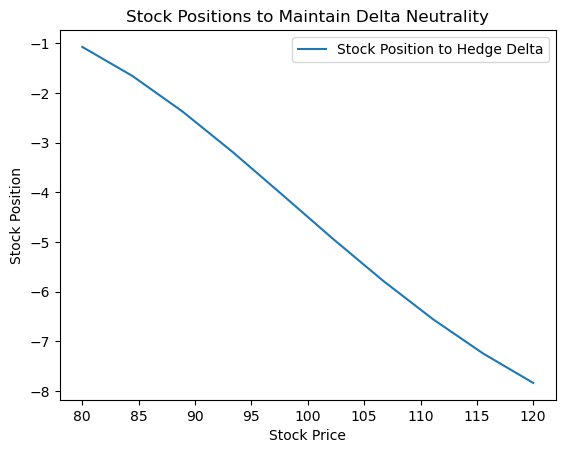

In [57]:
# Simulate stock price changes over time and rebalance
stock_prices = np.linspace(80, 120, 10)  # Simulating stock prices from $80 to $120
option_positions = []
stock_positions = []

for S_new in stock_prices:
    new_delta = delta(S_new, X, T, r, sigma, option_type='call')     # Recalculate delta with the new stock price
    total_delta = N_options * new_delta     # Total delta for the new price
    stock_position = -total_delta     # Stock position needed to maintain delta neutrality
    
    option_positions.append(total_delta)
    stock_positions.append(stock_position)
    
    print(f"Stock Price: {S_new}, Total Delta: {total_delta}, Stock Position to Hedge: {stock_position}")

# Plot the results (optional, can be added for visualization)
import matplotlib.pyplot as plt

plt.plot(stock_prices, stock_positions, label='Stock Position to Hedge Delta')
plt.xlabel('Stock Price')
plt.ylabel('Stock Position')
plt.title('Stock Positions to Maintain Delta Neutrality')
plt.legend()
plt.show()

---
#### 3.5 Using Historical Data from yfinance

We will use the ticker ___.

We require the following parameters:


In [56]:
def fetch_and_prepare_data(ticker_symbol, num_dates=5):
    ticker = yf.Ticker(ticker_symbol)
    expiration_dates = ticker.options[:num_dates]
    options_data = []

    for date in expiration_dates:
        options = ticker.option_chain(date)
        calls = options.calls.assign(option_type='call')
        puts = options.calls.assign(option_type='put')
        options_data.append(pd.concat([calls, puts]))
    
    df = pd.concat(options_data)
    current_time = pd.Timestamp.now(tz='UTC')
    df['time_to_expiration'] = (pd.to_datetime(df['lastTradeDate']) - current_time).dt.total_seconds() / (365 * 24 * 60 * 60)

    return df, expiration_dates

fetch_and_prepare_data("AAPL")

(         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
 0   AAPL240927C00100000 2024-09-19 13:37:33+00:00   100.0     126.26  126.70   
 1   AAPL240927C00105000 2024-09-03 18:16:00+00:00   105.0     117.60  121.55   
 2   AAPL240927C00110000 2024-08-19 13:30:07+00:00   110.0     115.93  109.55   
 3   AAPL240927C00130000 2024-08-27 15:22:23+00:00   130.0      99.40   96.75   
 4   AAPL240927C00140000 2024-09-19 14:24:56+00:00   140.0      89.27   86.75   
 ..                  ...                       ...     ...        ...     ...   
 24  AAPL241025C00275000 2024-09-19 19:29:03+00:00   275.0       0.06    0.00   
 25  AAPL241025C00280000 2024-09-20 18:05:28+00:00   280.0       0.04    0.00   
 26  AAPL241025C00285000 2024-09-18 17:26:05+00:00   285.0       0.01    0.00   
 27  AAPL241025C00295000 2024-09-18 13:30:05+00:00   295.0       0.02    0.02   
 28  AAPL241025C00300000 2024-09-20 17:20:26+00:00   300.0       0.02    0.01   
 
        ask  change  perce

---
#### 3.6 Key Insights
- Delta Neutrality: The stock position changes as the stock price changes to ensure the portfolio stays delta-neutral.
- Hedging: This strategy reduces directional risk, but other risks like gamma, vega, and theta may still impact the portfolio.
- Rebalancing: Continuous monitoring and rebalancing are required, especially when market conditions change rapidly.

Conclusion for Step 3:

A delta-neutral strategy is an effective way to manage risk in an options portfolio, minimizing exposure to price fluctuations in the underlying asset. However, this strategy does not account for other risks like volatility (Vega) or time decay (Theta), which may also need to be managed in a more sophisticated strategy. Regular rebalancing ensures that the portfolio remains hedged as market conditions change.

---

### Step 4: Portfolio Optimization and Risk Management

In this step, we will focus on **optimizing the portfolio** and managing risk using techniques such as position sizing, risk-adjusted returns, and risk metrics like **maximum drawdown** and **Sharpe ratio**. The goal is to build a robust algorithmic trading strategy that maximizes returns while keeping risks under control.

---

#### 4.1 Portfolio Optimization

**Overview**

Portfolio optimization is the process of selecting the best portfolio (allocation of assets) according to some objective, such as maximizing return or minimizing risk. In the context of options trading, we can adjust the **position sizing** of each trade based on factors like volatility, expected return, or market conditions.

**Key Concepts:**

- **Sharpe Ratio**: Measures risk-adjusted return (i.e., return per unit of risk). A higher Sharpe ratio indicates better risk-adjusted performance.
- **Position Sizing**: Determines the amount of capital to allocate to each trade based on its risk profile.
- **Volatility**: Higher volatility usually demands smaller positions to mitigate risk, while lower volatility may allow for larger positions.
- **Risk Parity**: A method of balancing the risk contribution of each asset in a portfolio, such that each asset contributes equally to overall portfolio risk.

---

#### 4.2 Position Sizing Based on Volatility

**Volatility-Adjusted Position Sizing**

A common approach to manage risk is to adjust position size according to the asset's volatility. This ensures that more volatile assets receive smaller allocations, while less volatile assets receive larger allocations.

**Formula for Volatility-Based Position Sizing:**

$$
\text{Position Size} = \frac{\text{Capital} \times \text{Risk Tolerance}}{\text{Volatility} \times \sqrt{\text{Position Variance}}}
$$

This formula adjusts the size of each position based on its volatility, ensuring that we don't over-allocate to riskier assets.

---

#### 4.3 Implementing Position Sizing in Python


In [36]:
# Parameters
capital = 100000  # Total capital available for trading
volatility = 0.2  # Asset volatility (e.g., 20%)
risk_tolerance = 0.02  # Risk tolerance per trade (e.g., 2% of total capital)
n_positions = 10  # Number of positions

# Calculate position size
position_size = (capital * risk_tolerance) / (volatility * np.sqrt(n_positions))
print(f"Volatility-Adjusted Position Size: ${position_size:.2f} per position")

Volatility-Adjusted Position Size: $3162.28 per position


This code calculates the position size based on volatility, ensuring that each trade has an appropriate risk-adjusted allocation.

---
#### 4.4 Risk Management Techniques

- Maximum Drawdown (MDD): The maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. It measures the largest single drop in portfolio value over a period.

$$
\text{MDD} = \frac{\text{Peak Value} - \text{Trough Value}}{\text{Peak Value}} \times 100
$$

A lower drawdown indicates better risk management, as it means the portfolio doesn’t experience large, sustained losses

In [37]:
# Example portfolio returns (simulated)
portfolio_returns = np.array([0.05, -0.02, 0.04, -0.03, -0.10, 0.02, 0.06, -0.01, 0.03, 0.07])

# Cumulative returns
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

# Calculate drawdown
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (peak - cumulative_returns) / peak

# Maximum drawdown
max_drawdown = np.max(drawdown)
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

Maximum Drawdown: 193.71%


- Sharpe Ratio: A widely used measure of risk-adjusted return. It is calculated as the excess return (portfolio return minus risk-free rate) divided by the standard deviation (volatility) of returns:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

Where:
- $ R_p $ = Portfolio return
- $ R_f $ = Risk-free rate
- $ \sigma_p $ = Portfolio standard deviation


In [38]:
portfolio_return = np.mean(portfolio_returns)
portfolio_std_dev = np.std(portfolio_returns)
risk_free_rate = 0.01  # 1% risk-free rate

sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 0.02


A Sharpe Ratio above 1 is considered good, above 2 is very good, and above 3 is excellent. This helps us evaluate whether our portfolio’s returns justify the risks taken.

#### 4.5 Risk Parity Strategy

Another advanced portfolio optimization technique is Risk Parity, which allocates positions in such a way that each asset contributes equally to the overall portfolio risk. This creates a more balanced risk exposure across assets.


In [39]:
volatilities = np.array([0.15, 0.2, 0.1, 0.25, 0.3])  # Example volatilities
initial_weights = np.ones(len(volatilities)) / len(volatilities)

# Objective: Minimize the difference between risk contribution of each asset
def risk_parity_objective(weights, volatilities):
    portfolio_volatility = np.sqrt(np.dot(weights.T, weights * volatilities**2))
    risk_contribution = (weights * volatilities) / portfolio_volatility
    return np.std(risk_contribution)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # Constraint: Weights must sum to 1

bounds = [(0, 1)] * len(volatilities) # Bounds: Each weight between 0 and 1

optimized_weights = minimize(risk_parity_objective, initial_weights, args=(volatilities,), 
                             method='SLSQP', bounds=bounds, constraints=constraints)

print(f"Optimized Weights for Risk Parity: {optimized_weights.x}")

Optimized Weights for Risk Parity: [0.22988588 0.17241451 0.34482713 0.13793009 0.11494238]
